In [1]:
# Cell 1: Setup and Load Average Yield Data
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob
import re

# --- Load all average yield data ---
CROPS = ['maize', 'rice', 'wheat', 'soybean']
avg_yields = {}
print("--- Loading and processing average yield data ---")

for crop in CROPS:
    data_path = f'../data/{crop}/yield_*.nc4'
    filepaths = sorted(glob.glob(data_path))
    if not filepaths:
        print(f"No files found for {crop}, skipping.")
        continue
    years = [int(re.search(r'(\d{4})\.nc4$', f).group(1)) for f in filepaths]
    
    with xr.open_mfdataset(data_path, combine='nested', concat_dim='time') as ds:
        ds = ds.assign_coords(time=years)
        # Use dictionary-style access ds['var']
        avg_yields[crop] = ds['var'].mean(dim='time').compute()
        print(f"Processed: {crop}")
        
print("\nAll average yield data loaded.")

--- Loading and processing average yield data ---
Processed: maize
Processed: rice
Processed: wheat
Processed: soybean

All average yield data loaded.


## Step 1: Defining the "Northern Italy 4-Crop" Mask

We will create a precise mask to isolate only the grid cells that meet two criteria:
1. They are located within our defined bounding box for Northern Italy.
2. All four major crops (Maize, Rice, Wheat, Soybean) are grown there.

Found 44 grid cells that meet both criteria.


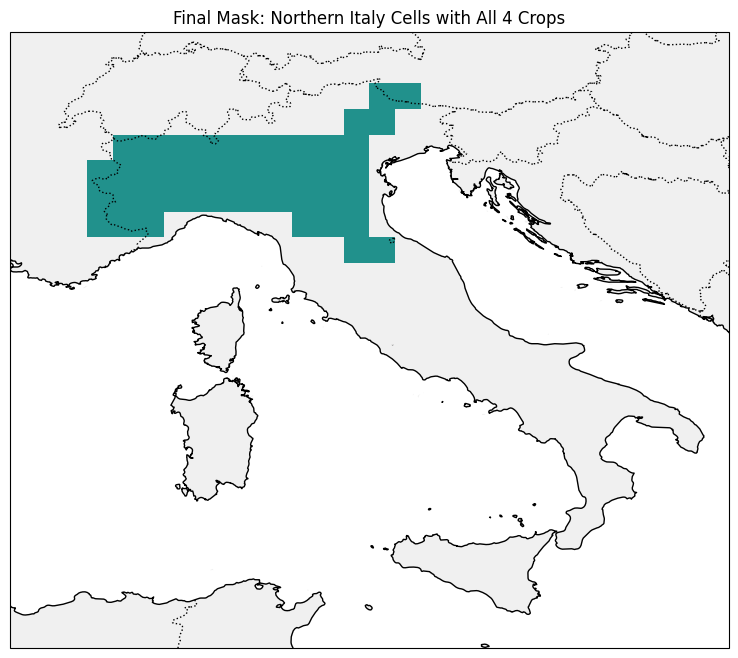

In [3]:
# Cell 2: Create and Visualize the Final Mask

# --- 1. Define the Geographical Bounding Box for Northern Italy ---
# These are our initial estimates. The map will show if they are good.
n_italy_bounds = {'lon': slice(6, 13), 'lat': slice(43, 47)}

# Create a boolean mask for the geographical area
# We use one of our loaded yield maps as a template for the grid shape
template_grid = avg_yields['maize']
geo_mask = xr.ones_like(template_grid, dtype=bool).where(
    (template_grid.lat >= n_italy_bounds['lat'].start) & (template_grid.lat <= n_italy_bounds['lat'].stop) &
    (template_grid.lon >= n_italy_bounds['lon'].start) & (template_grid.lon <= n_italy_bounds['lon'].stop),
    False
)

# --- 2. Create the "4-Crop" Mask ---
# Start with a mask that is True everywhere
four_crop_mask = xr.ones_like(template_grid, dtype=bool)

# Use a logical AND to sequentially filter the mask
# A grid cell will only remain True if ALL crops are present
for crop_name, yield_data in avg_yields.items():
    # We consider a crop "present" if its average yield is > 0.1 t/ha
    four_crop_mask = four_crop_mask & (yield_data > 0.1)

# --- 3. Combine the Masks ---
# The final mask is True only where BOTH the geo_mask AND four_crop_mask are True
final_mask = geo_mask & four_crop_mask
print(f"Found {int(final_mask.sum())} grid cells that meet both criteria.")

# --- 4. Verification Plot ---
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent to zoom in on Italy for a better view
ax.set_extent([5, 19, 36, 48], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='#f0f0f0')
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the final mask. The `where` function will only show the True values.
final_mask.where(final_mask).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    add_colorbar=False
)

plt.title('Final Mask: Northern Italy Cells with All 4 Crops')
plt.show()

## Step 2: Process the Maize Yield Data

Now that we have our final mask, we will use it to extract the full 36-year time-series of maize yields for our 44 target grid cells.

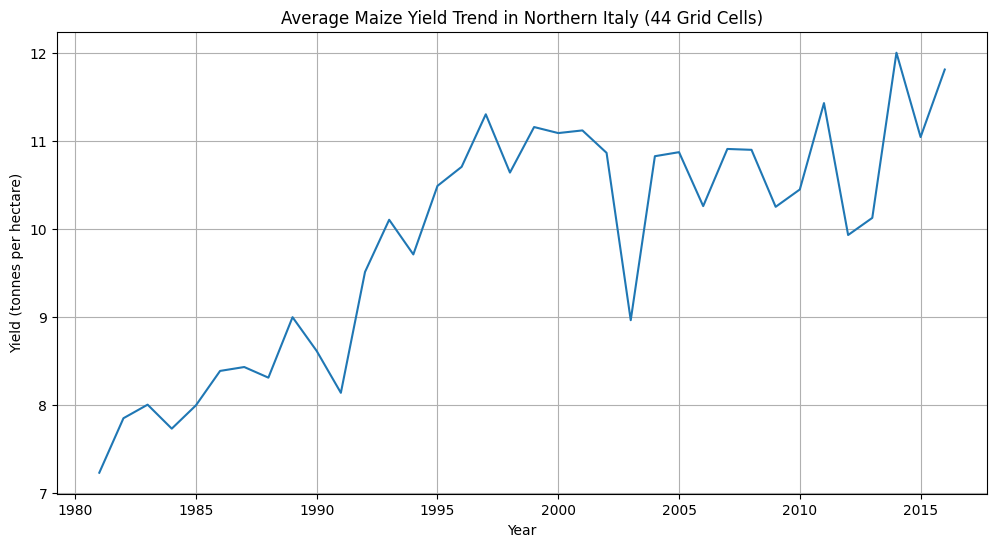


--- Visual Verification: Displaying masked data for the year 2015 ---


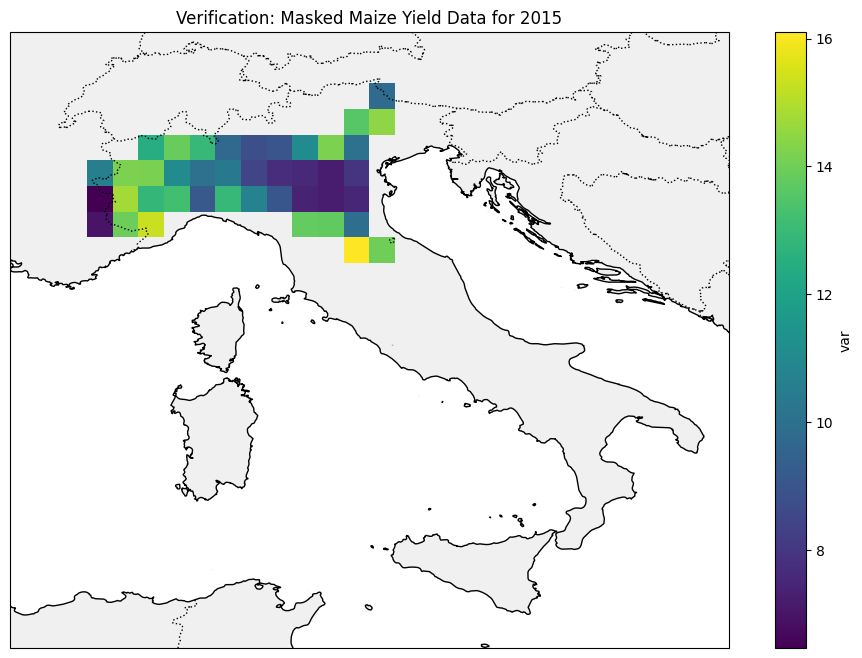

In [5]:
# Cell 3: Extract, Verify, and Plot Regional Maize Yield

# --- 1. Load the full 36-year maize yield data ---
CROP_TO_ANALYZE = 'maize'
data_path = f'../data/{CROP_TO_ANALYZE}/yield_*.nc4'
filepaths = sorted(glob.glob(data_path))
years = [int(re.search(r'(\d{4})\.nc4$', f).group(1)) for f in filepaths]

with xr.open_mfdataset(data_path, combine='nested', concat_dim='time') as ds:
    ds = ds.assign_coords(time=years)
    full_yield_data = ds['var'].compute()

# --- 2. Apply the final_mask ---
# The .where() function keeps data where the mask is True and sets everything else to NaN
regional_yield = full_yield_data.where(final_mask)

# --- 3. Calculate and Plot the Average Trend ---
# We calculate the mean over all selected grid cells for each year
mean_yield_trend = regional_yield.mean(dim=['lat', 'lon'])

plt.figure(figsize=(12, 6))
mean_yield_trend.plot()
plt.title(f'Average Maize Yield Trend in Northern Italy (44 Grid Cells)')
plt.ylabel('Yield (tonnes per hectare)')
plt.xlabel('Year')
plt.grid(True)
plt.show()

# --- 4. VISUAL VERIFICATION: Map the Masked Data for a Single Year ---
print("\n--- Visual Verification: Displaying masked data for the year 2015 ---")

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([5, 19, 36, 48], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='#f0f0f0')
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Select and plot the data for just one year from our masked dataset
regional_yield.sel(time=2015).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis'
)

plt.title('Verification: Masked Maize Yield Data for 2015')
plt.show()

## Step 3: Process the Climate Data (Temperature)

Now we will process the high-resolution monthly temperature data to create a single, analysis-ready time-series of the average growing season temperature for our specific 44-cell region.

Loading full monthly temperature data (1981-2016)...


C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on th

Climate data loaded.


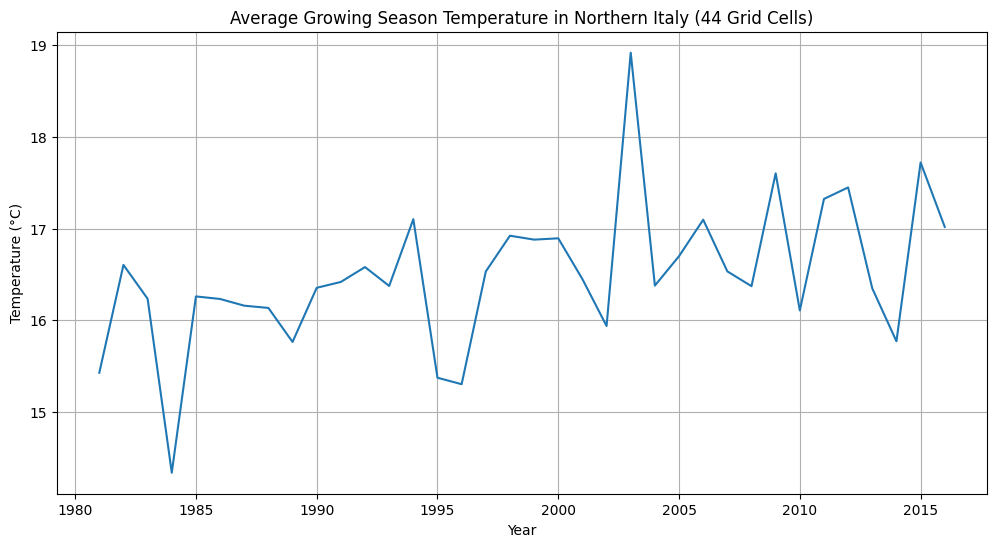


--- Final Processed Temperature Data for Analysis ---
<xarray.DataArray 't2m' (year: 36)> Size: 144B
dask.array<mean_agg-aggregate, shape=(36,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    number   int64 8B 0
    step     timedelta64[ns] 8B 1 days
    surface  float64 8B 0.0
  * year     (year) int64 288B 1981 1982 1983 1984 1985 ... 2013 2014 2015 2016


In [8]:
# Cell 4: Process and Align Temperature Data (Corrected for Coordinate Mismatch)
import pandas as pd

# --- 1. Research and Define the Growing Season ---
growing_season_months = [5, 6, 7, 8, 9]

# --- 2. Load the full 36-year monthly temperature data ---
print("Loading full monthly temperature data (1981-2016)...")
CLIMATE_PATH = '../data/climate_monthly_full/era5_land_monthly_*.grib'
ds_temp_full = xr.open_mfdataset(
    CLIMATE_PATH, 
    engine='cfgrib',
    combine='nested',
    concat_dim='time',
    backend_kwargs={'filter_by_keys': {'shortName': '2t'}}
)
ds_temp_full = ds_temp_full.assign_coords(time=pd.to_datetime(ds_temp_full.time.values))
temp_celsius = ds_temp_full['t2m'] - 273.15
print("Climate data loaded.")

# --- 3. Filter by Season and Aggregate to Yearly Values ---
seasonal_temp = temp_celsius.where(temp_celsius['time.month'].isin(growing_season_months))
yearly_avg_temp = seasonal_temp.groupby('time.year').mean(dim='time')

# --- 4. Align the Grids (Regrid by Averaging) ---
# Coarsen to average the 0.1° data into ~0.5° blocks
coarsened_temp = yearly_avg_temp.coarsen(latitude=5, longitude=5, boundary='trim').mean()

# --- THIS IS THE CRITICAL FIX ---
# Rename the coordinates of the climate data to match the yield data's mask
coarsened_temp = coarsened_temp.rename({'latitude': 'lat', 'longitude': 'lon'})
# --- END FIX ---

# Now that the names match, we can align them perfectly to the yield grid
regridded_temp = coarsened_temp.interp_like(regional_yield, method='nearest')

# --- 5. Apply our final_mask ---
# This will now work correctly because both datasets have 'lat' and 'lon' coordinates
regional_temp_ts = regridded_temp.where(final_mask).mean(dim=['lat', 'lon'])

# --- 6. Verification Plot ---
plt.figure(figsize=(12, 6))
regional_temp_ts.plot()
plt.title('Average Growing Season Temperature in Northern Italy (44 Grid Cells)')
plt.ylabel('Temperature (°C)')
plt.xlabel('Year')
plt.grid(True)
plt.show()

print("\n--- Final Processed Temperature Data for Analysis ---")
print(regional_temp_ts)

## Step 4: Combine and Analyze Yield vs. Temperature

Now that we have clean, processed, and aligned time-series for both maize yield and growing season temperature, we can combine them to create our first scientifically sound vulnerability plot.

In [11]:
# Cell 5: Create and Save the Final Compact Dataset
import pandas as pd

# --- 1. Combine the Processed Data into a DataFrame ---
# We use the raw, unprocessed mean_yield_trend from Cell 3
# We use the processed regional_temp_ts from Cell 4

final_df = pd.DataFrame({
    'year': mean_yield_trend.time.values,
    'maize_yield': mean_yield_trend.values,
    'temperature': regional_temp_ts.values
})

# --- 2. Save the DataFrame to a CSV file ---
# CSV is a simple, universal format (rows and columns) that is perfect for this.
output_dir = '../data/analysis_ready/'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'n_italy_maize_yearly_data.csv')

final_df.to_csv(output_file, index=False)

# --- 3. Display the Final DataFrame ---
print("--- Final, Compact Dataset for Northern Italy Maize ---")
print(f"Dataset saved to: {output_file}")
print("\nHere is a preview of the first 5 rows:")
print(final_df.head().to_string())

--- Final, Compact Dataset for Northern Italy Maize ---
Dataset saved to: ../data/analysis_ready/n_italy_maize_yearly_data.csv

Here is a preview of the first 5 rows:
   year  maize_yield  temperature
0  1981     7.227563    15.429763
1  1982     7.847305    16.603651
2  1983     8.001379    16.235352
3  1984     7.728883    14.340881
4  1985     7.993611    16.260496


In [14]:
# Final Cell (Corrected for KeyError): Create the Complete, Unaggregated Dataset

import xarray as xr
import pandas as pd
import numpy as np
from scipy.signal import detrend
import os
import glob
import re

# --- 1. Define Regions ---
yield_region = {'lon': slice(6, 13), 'lat': slice(43, 47)}
climate_region = {'longitude': slice(6, 13), 'latitude': slice(47, 43)}

# --- 2. Process Yield Data ---
print("--- Processing Yield Data ---")
CROP_TO_ANALYZE = 'maize'
data_path = f'../data/{CROP_TO_ANALYZE}/yield_*.nc4'
filepaths = sorted(glob.glob(data_path))
years = [int(re.search(r'(\d{4})\.nc4$', f).group(1)) for f in filepaths]
with xr.open_mfdataset(data_path, combine='nested', concat_dim='time') as ds:
    ds = ds.assign_coords(time=years)
    regional_yield_lazy = ds['var'].sel(**yield_region)
    regional_yield = regional_yield_lazy.compute()
regional_yield = regional_yield.where(final_mask.sel(**yield_region))
print("Yield data for the 44-cell region has been extracted.")

# --- 3. Process All Climate Stressors ---
print("\n--- Processing Climate Data ---")
STRESSORS = {
    '2t': {'name': 'temperature', 'agg': 'mean'},
    'tp': {'name': 'precipitation', 'agg': 'sum'},
    'swvl1': {'name': 'soil_water_l1', 'agg': 'mean'},
    'ssr': {'name': 'solar_radiation', 'agg': 'mean'},
    'pev': {'name': 'potential_evaporation', 'agg': 'mean'}
}
processed_stressors = {}

# Load the temperature data once to create the growing season mask
with xr.open_dataset('../data/climate_monthly_full/era5_land_monthly_1995.grib', engine='cfgrib', backend_kwargs={'filter_by_keys': {'shortName': '2t'}}) as ds_temp_sample:
    temp_celsius = ds_temp_sample['t2m'].sel(**climate_region) - 273.15
    growing_season_mask = temp_celsius > 10

for short_name, info in STRESSORS.items():
    print(f"Processing {info['name']}...")
    with xr.open_mfdataset(f'../data/climate_monthly_full/era5_land_monthly_*.grib', engine='cfgrib', combine='nested', concat_dim='time', backend_kwargs={'filter_by_keys': {'shortName': short_name}}) as ds_climate:
        ds_climate = ds_climate.assign_coords(time=pd.to_datetime(ds_climate.time.values))
        
        # --- THIS IS THE CRITICAL FIX ---
        # Get the actual variable name from the dataset (e.g., 't2m')
        var_name = list(ds_climate.data_vars)[0]
        # Now use this correct name to access the data
        regional_climate = ds_climate[var_name].sel(**climate_region)
        # --- END FIX ---
        
        seasonal_data = regional_climate.where(growing_season_mask)
        if info['agg'] == 'sum':
            yearly_agg = seasonal_data.groupby('time.year').sum(dim='time')
        else: # 'mean'
            yearly_agg = seasonal_data.groupby('time.year').mean(dim='time')
            
        if short_name == '2t': yearly_agg -= 273.15
        if short_name == 'tp': yearly_agg *= 1000
            
        coarsened = yearly_agg.coarsen(latitude=5, longitude=5, boundary='trim').mean()
        coarsened = coarsened.rename({'latitude': 'lat', 'longitude': 'lon'})
        regridded = coarsened.interp_like(regional_yield, method='nearest')
        
        processed_stressors[info['name']] = regridded.where(final_mask.sel(**yield_region))

# --- 4. Combine into a Single xarray Dataset and then DataFrame ---
final_ds = xr.Dataset({'maize_yield': regional_yield, **processed_stressors})
final_df = final_ds.to_dataframe().dropna().reset_index().rename(columns={'time': 'year'})

# --- 5. Save and Display ---
output_dir = '../data/analysis_ready/'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'n_italy_maize_gridcell_all_stressors.csv')
final_df.to_csv(output_file, index=False)

print(f"\n--- Final, Compact Dataset (with {len(final_df)} rows) ---")
print(f"Dataset saved to: {output_file}")
print("\nHere is a preview of the first 5 rows:")
print(final_df.head().to_string())

--- Processing Yield Data ---


Ignoring index file '../data/climate_monthly_full/era5_land_monthly_1995.grib.47d85.idx' incompatible with GRIB file


Yield data for the 44-cell region has been extracted.

--- Processing Climate Data ---


C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Processing temperature...


C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on th

Processing precipitation...


C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on th

Processing soil_water_l1...


C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on th

Processing solar_radiation...


C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on th

Processing potential_evaporation...


C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on th


--- Final, Compact Dataset (with 1465 rows) ---
Dataset saved to: ../data/analysis_ready/n_italy_maize_gridcell_all_stressors.csv

Here is a preview of the first 5 rows:
    lon    lat  year  year  maize_yield  number   step  surface  temperature  precipitation  depthBelowLandLayer  soil_water_l1  solar_radiation  potential_evaporation
0  6.75  44.25  1982  1995     4.623395       0 1 days      0.0    12.600345      11.806308                  0.0       0.385267       18190518.0              -0.006617
1  6.75  44.25  1983  1995     4.611639       0 1 days      0.0    12.600345      11.806308                  0.0       0.385267       18190518.0              -0.006617
2  6.75  44.25  1984  1995     3.952143       0 1 days      0.0    12.600345      11.806308                  0.0       0.385267       18190518.0              -0.006617
3  6.75  44.25  1985  1995     5.707234       0 1 days      0.0    12.600345      11.806308                  0.0       0.385267       18190518.0             